# DataCleaning (Class Data)

In [16]:
#import required modules:
import numpy as np
import pandas as pd
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose


## <span style=color:#7fc97f>Description of the Class Data</span>
#### The class has 2 inputs: A Pandas DataFrame and a name:

--> To create an instance ot the Class Data, use following lines:
```json
dataframe = pd.read_csv("PATH TO DATA")
name="DESIRED NAME"
LakeAegeri=Data(dataframe,name)
```
<br>
<br>

#### <span style=color:#7fc97f>The Class has various methods:</span> <br>
#####  <span style=color:#d9f0a3>1. The INSTANCE_CLASS_DATA.calc_rolling_statistics(column,window,plot="n",save_plot="n")</span>
This method will calculate the rolling statistics and outputs a plot.

If you don't want the plot plotted in the notebook, use show_plot="n".

If you want to save the plot in the /data/output/.. folder:
- save_plot="y" -> It asks you to input a name without a space.
- save_plot="CUSTOM_NAME" -> It creates a plot with the name CUSTOM_NAME in the specified folder
- save_plot="n": It will not save the created figure
If you want to define the rolling window, use window=INTEGER
<br>
<br>

##### <span style=color:#d9f0a3>2. The INSTANCE_CLASS_DATA.check_stationarity(column):</span>
This method will check the stationarity using the Augmented Dickey-Fuller Test (ADF). As an input use the column you want the stationarity checked on.
<br>
<br>

##### <span style=color:#d9f0a3>3. INSTANCE_CLASS_DATA.detect_outlier(self, column, splines_imputation="y", PERIOD=24, display_plots="y"):</span>

This method will clean the data with help of the seasonal decomposition of the specified column (column=COLUMN_NAME).

The method returns an instance of the class Data (with the whole DataFrame with the (timeseries) cleaned column). The physical impossible outliers are not cleaned in this method.

If you want the more "fancy" Splines Imputation, use splines_imputation="y". It looks at outlier and puts a mathematical function over the dataset. The method estimates values that minimize overall curvature, thus obtaining a smooth surface passing through the input points. Spline interpolation is computationally efficient and can be used to interpolate large datasets quickly and accurately. Otherwise, use knn_imputation="n" to use the simple imputer: It looks at the normalized residuals and sets >3 values to 3 and <-3 values to -3. In the last step.

PERIOD: If you want to change the period of the data, change the PERIOD parameter.

Display plots in the notebook: If you want to display the plots, use display_plots="y", else display_plots="n"
<br>
<br>

##### <span style=color:#d9f0a3>4. INSTANCE_CLASS_DATA.remove_outliers_temperature(self, skin_column_name="y", bulk_column_name="y1", airtemp_column_name="air_temp", imputation="y"):</span>

This method will clean the physically impossible outliers of the skin, bulk and air temperatures.

skin_column_name="XXX" : input the name of the skin temperature column
bulk_column_name="XXX" : input the name of the bulk temperature column
airtemp_column_name="XXX" : input the name of the air temperature column

imputation="y": If you want the physically impossible values imputed, make imputation="y". The imputation method is the Splines method. It looks at outlier and puts a mathematical function over the dataset. The method estimates values that minimize overall curvature, thus obtaining a smooth surface passing through the input points. Spline interpolation is computationally efficient and can be used to interpolate large datasets quickly and accurately.
imputation="n": If you want the physically impossible values deleted, use imputation="n". Note, that many data is lost due to this process, because it will delete the entire column.
<br>
<br>

##### <span style=color:#d9f0a3>5. Instance_CLASS_DATA.remove_outliers_static(self, column_name, imputation="y"):</span>

This method will remove the statistical outliers of a column. Note, that this column will not look at the seasonality in the data, and will use the normalized values of the selected column (column_name="XXX") to determine the outliers.

If the Z-Score (COLUMN_VALUE-mean/std) exceeds 3 (or -3), the point will be considered as an outlier.
-> If you want to impute the missing data with the Splines Imputation, use imputation = "y", else imputation = "n". The Spline Imputation looks at the missing points (here the outliers) and puts a mathematical function over the dataset. The method estimates values that minimize overall curvature, thus obtaining a smooth surface passing through the input points. Spline interpolation is computationally efficient and can be used to interpolate large datasets quickly and accurately.




In [17]:
class Data:
    def __init__(self, dataframe, name, set_index_datetime_int="y"):
        self.name = name
        self.dataframe = dataframe
        self.columns = self.dataframe.columns
        #convert the strings and add the datetime column to index
        self.dataframe["datetime"] = pd.to_datetime(self.dataframe["datetime"])

        index_name = self.dataframe.index.name  #this is used further below in the else: statement
        self.dataframe = self.dataframe.reset_index()

        if set_index_datetime_int == "y":
            self.dataframe.index = self.dataframe["x"]
            self.dataframe = self.dataframe.drop(columns=["x", "index"])
        else:
            self.dataframe.index = self.dataframe[index_name]
            self.dataframe = self.dataframe.drop(columns=[index_name])

    def __repr__(self):
        return f"DataFrame {name} with columns: {str(list(self.columns))}"

    def calc_rolling_statistics(self, column, window, show_plot="no", save_plot="no"):
        mean_rm = self.dataframe[column].rolling(window=window).mean()
        std_rm = self.dataframe[column].rolling(window=window).std()

        plt.style.context
        plt.rc('figure', figsize=(10, 6))
        fig, ax = plt.subplots(1, sharex=False, sharey=False)
        ax.plot(self.dataframe["datetime"], self.dataframe[column], color='red', label='Actual', alpha=0.7)
        ax.plot(self.dataframe["datetime"], mean_rm, color='green', label=f'Rolling Mean (window: {window})', alpha=0.7)
        ax.plot(self.dataframe["datetime"], std_rm, color='black', label=f'Rolling Std (window: {window})', alpha=0.7)
        plt.legend(loc='best')
        plt.title(f'Rolling Mean & Standard Deviation of {column}')

        if save_plot == "y":
            plt.savefig(f"./data/output_png/{input('How should the figure be named? (no Spaces!)')}.png")
        elif save_plot != "no":
            plt.savefig(f"./data/output_png/{save_plot}.png")

        if show_plot == "n":
            plt.close()
        plt.show(block=False)

    def check_stationarity(self, column):
        print(f"Visual check is advised with {self.name}.calc_rolling_statsitics(...,plot='Y')")
        print(
            "->  A stationary Time Series is one which characteristics like mean and variance does not change over time.")
        print(
            "Another way of checking for stationarity of the time series is using Augmented Dickey-Fuller (ADF) Test to check stationarity:")
        print("--------------------")
        print('Dickey-Fuller Test: ')
        X = self.dataframe[column].dropna().values
        dftest = adfuller(X, autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'No. of Obs'])
        for key, value in dftest[4].items():
            dfoutput['Critical Value (%s)' % key] = value

        if list(dfoutput.items())[1][1] > 0.05:
            print(
                f"with a p-value of {round(list(dfoutput.items())[1][1], 3)}, we fail to reject the null hypothesis, that the data is stationary.")
            print(dfoutput)
            return False
        else:
            print(
                f"with a p-value of {round(list(dfoutput.items())[1][1], 3)}, we reject the null hypothesis, that the data is stationary.")
            print(dfoutput)

    def detect_outlier(self, column, splines_imputation="y", PERIOD=24, display_plots="y"):
        ### 1. Prepare Dataset for the seasonal seasonal_decompose function:
        pd.set_option('display.max_rows', None)
        dataframe_noNAN = self.dataframe.dropna()
        dataframe_noNAN = dataframe_noNAN.reset_index()
        dataframe_noNAN = dataframe_noNAN.set_index("datetime")

        #set plot size:
        plt.rc('figure', figsize=(10, 6))
        plt.rc('font', size=10)

        ### 2. Seasonal decompose
        result = seasonal_decompose(dataframe_noNAN[[column]], period=PERIOD,model="additive")

        #plot the seseasonal_decompose:
        fig, ax = plt.subplots(4, sharex=False, sharey=False)
        fig.subplots_adjust(bottom=7, top=9)

        ax[0].plot(result.observed, color="blue")
        ax[0].set_title("Result observed")

        ax[1].plot(result.seasonal, color="red")
        ax[1].set_title(f"seasonality of Period {PERIOD}")

        ax[2].plot(result.trend, color="green")
        ax[2].set_title("Trend")

        ax[3].plot(result.resid, color="orange")
        ax[3].set_title("Residuals")

        if display_plots != "y":
            plt.close()
        plt.show()

        ## 2.1 residuals (imputation yes or no)
        seasonal_df = result.seasonal.to_frame()
        trend_df = result.trend.to_frame()
        residuals_df = result.resid.to_frame()

        # 2.1.1 Normalize residuals:
        mean = residuals_df.mean()
        std = residuals_df.std()
        residuals_df_norm = residuals_df.copy()
        residuals_df_norm = (residuals_df_norm[["resid"]] - mean[0]) / std[0]

        # 2.1.2 If the normalized residuals exceed +/- 3, then this is considered an outlier:
        residuals_df_norm['is_outlier'] = np.where((residuals_df_norm['resid'] > 3) | (residuals_df_norm['resid'] < -3),
                                                   True, False)
        print(f"----------------------------------------\n \033[94m{residuals_df_norm['is_outlier'].value_counts()[True]} values (residuals) are dropped/imputed in {column}. \033[0m")

        #plot exceeded residuals:
        fig, ax = plt.subplots()
        ax.scatter(residuals_df_norm.reset_index()["datetime"], residuals_df_norm.reset_index()["resid"],
                   c=residuals_df_norm["is_outlier"], cmap=cm.Set2, s=1)
        ax.axhline(3, color="red")
        ax.axhline(-3, color="red")
        if display_plots != "y":
            plt.close()
        plt.show()

        # 2.1.3 IMPUTATION: if needed
        if splines_imputation == "y":
            print(
                f"---> Splines Imputation of {column}. It looks at outlier and puts a mathematical function over the dataset. The method estimates values that minimize overall curvature, thus obtaining a smooth surface passing through the input points. Spline interpolation is computationally efficient and can be used to interpolate large datasets quickly and accurately.\nThe method returns an instance of the class Data (with the whole DataFrame with the (timeseries) cleaned column {column}). The physical impossible outliers are not cleaned in this method.")
            #IMPUTATION:
            residuals_df_norm = residuals_df_norm.dropna()
            residuals_df_imputed = residuals_df_norm.copy()
            residuals_df_imputed['resid'] = np.where(
                (residuals_df_imputed['resid'] > 3) | (residuals_df_imputed['resid'] < -3), np.nan,
                residuals_df["resid"].dropna())

            residuals_cleaned = residuals_df_imputed[['resid']].interpolate(option="spline")  #spline interpolation



        else:  #ASSUMING THAT ALL RESIDUALS WILL BE SET TO 3 or -3 (normalized) WHEN THEY ARE ABOVE 3 OR BELOW -3
            print(
                f"---> Simple imputation of {column}: It looks at the normalized residuals and sets >3 values to 3 and <-3 values to -3.\nThe method returns an instance of the class Data (with the whole DataFrame with the (timeseries) cleaned column {column}). The physical impossible outliers are not cleaned in this method.")

            residuals_df_norm = residuals_df_norm.dropna()
            residuals_df_norm.loc[residuals_df_norm["resid"] > 3, "resid"] = 3
            residuals_df_norm.loc[residuals_df_norm["resid"] < -3, "resid"] = -3
            residuals_df_norm = residuals_df_norm.drop(columns=["is_outlier"])

            # De-Normalize (inverse of residuals_df_norm = (residuals_df_norm[["resid"]] - mean[0])/std[0])
            residuals_cleaned = residuals_df_norm.mul({"resid": std[0]}).add({"resid": mean[0]})

        #Compose the Timeseries again (by adding the components residuals, seasonality and trend)
        fig, ax = plt.subplots()
        ax.scatter(residuals_cleaned.reset_index()["datetime"], residuals_cleaned.reset_index()["resid"], s=1)
        if display_plots != "y":
            plt.close()
        plt.show()

        #merging the timestamps of the 3 DataFrame's
        data_cleaned = residuals_cleaned.join(seasonal_df).join(trend_df)
        data_cleaned[column] = data_cleaned["seasonal"] + data_cleaned["resid"] + data_cleaned["trend"]
        #combine the data_cleaned (with 1 column) with the original dataframe
        temp = self.dataframe.copy()
        temp = temp.reset_index()
        temp = temp.set_index("datetime")
        data_cleaned = data_cleaned.drop(columns=["seasonal", "trend", "resid"]).join(temp, how="left", lsuffix='left', rsuffix='right')

        #del data_cleaned[f"{column}right"] #delete column

        data_cleaned=data_cleaned.rename(columns={f"{column}left":column})
        temp = None
        data_cleaned = data_cleaned.reset_index()
        data_cleaned = data_cleaned.set_index("x")
        return Data(data_cleaned, self.name, set_index_datetime_int="n")

    def remove_outliers_temperature(self, skin_column_name="y", bulk_column_name="y1", airtemp_column_name="air_temp", imputation="y"):

        result_df = self.dataframe.copy()
        # Remove any rows where either "skinTemp" or "bulkTemp" is above 35
        df_cleaned = result_df[(result_df[skin_column_name] <= 35) & (result_df[bulk_column_name] <= 35)]

        result_df.loc[result_df[skin_column_name] >= 35, skin_column_name] = np.NaN
        result_df.loc[result_df[skin_column_name] <= 0, skin_column_name] = np.NaN

        #https://www.meteoswiss.admin.ch/climate/the-climate-of-switzerland/records-and-extremes (to filter out extremas in air temperature
        result_df.loc[result_df[airtemp_column_name] >= 41.5, airtemp_column_name] = np.NaN
        result_df.loc[result_df[airtemp_column_name] <= -41.8, airtemp_column_name] = np.NaN

        result_df.loc[result_df[bulk_column_name] >= 35, bulk_column_name] = np.NaN
        result_df.loc[result_df[bulk_column_name] <= 0, bulk_column_name] = np.NaN

        print(
            f"----------------------------------------\n \033[94m{result_df[skin_column_name].isna().sum()} values are dropped/imputed in skin temperature of {self.name}.\n{result_df[bulk_column_name].isna().sum()} values are dropped/imputed in bulk temperature  of {self.name}.\n{result_df[airtemp_column_name].isna().sum()} values are dropped/imputed in air temperature  of {self.name}. \033[0m")

        if imputation == "y":
            #implement IMPUTATION here
            print(
                f"---> Spline interpolation Imputation of skin and bulk temperature: Using a mathematical function, the method estimates values that minimize overall curvature, thus obtaining a smooth surface passing through the input points. \nThe function returns a (Physical) cleaned DataFrame with the columns airtemp, skin & bulk temperature (physicaly) cleaned. The other parameters are not yet cleaned.")

            #IMPUTATION SPLINES Imputer:
            result_df[[skin_column_name]] = result_df[[skin_column_name]].interpolate(option="spline")
            result_df[[bulk_column_name]] = result_df[[bulk_column_name]].interpolate(option="spline")
            result_df[[airtemp_column_name]] = result_df[[airtemp_column_name]].interpolate(option="spline")

        else:
            print("The rows with physical impossible values are deleted.")

        result_df = result_df.dropna()  #to delete the nan (in spline if e.g. the first value is a NaN, then the spline interpolation can't handle this value)
        return Data(result_df, self.name, set_index_datetime_int="n")

    def remove_outliers_static(self, column_name, imputation="y"):
        # Calculate the z-score for the column
        z_scores = np.abs((self.dataframe[column_name] - self.dataframe[column_name].mean()) / self.dataframe[column_name].std())
        z_scores.loc[z_scores == np.nan,] = 999  #will be later converted to nan again. this is used to have the same lengths

        # filter the dataframe and replace <=3 values with NaN's (to further interpolate or drop)
        result_clean = self.dataframe.copy()
        result_clean["zscore"] = z_scores.values

        result_clean.loc[result_clean["zscore"] > 3, column_name] = np.NaN  #when z-score is over 3, then the point will be an outlier
        result_clean.loc[result_clean["zscore"] < -3, column_name] = np.NaN  #when z-score is lower than  -3, then the point will be an outlier

        print(
            f"----------------------------------------\n\033[94m{result_clean[column_name].isna().sum()} values are dropped/imputed in {column_name}.\033[0m")
        if imputation == "y":
            #implement IMPUTATION here
            print(
                f"---> Spline interpolation Imputation of {column_name}: Using a mathematical function, the method estimates values that minimize overall curvature, thus obtaining a smooth surface passing through the input points. \nThe function returns a (Physical) cleaned DataFrame with the column {column_name}(statically) cleaned. The other parameters are not yet cleaned.")

            #IMPUTATION SPLINES Imputer:
            result_clean[[column_name]] = result_clean[[column_name]].interpolate(option="spline")

        else:
            print("The rows with physical impossible values are deleted. ")

        result_clean = result_clean.dropna()  #to delete the nan's (in spline if e.g. the first value is a NaN, then the spline interpolation can't handle this value)
        result_clean = result_clean.drop(columns=["zscore"])

        # Return the DataFrame with the cleaned column
        return Data(result_clean, self.name, set_index_datetime_int="n")



    def rename_columns(self,columns={"y": "skin_temp", "y1": "bulk_temp"}):
        self.dataframe.rename(columns=columns,inplace=True)
        self.columns = self.dataframe.columns


In [18]:
dataframe = pd.read_csv("./data/df_aegeri_skin.csv")
name = "LakeAegeri raw"
LakeAegeri = Data(dataframe, name)

In [19]:
Output=Data(LakeAegeri.detect_outlier("y",PERIOD=144,display_plots="n",splines_imputation="y").dataframe,"name",set_index_datetime_int="n")

----------------------------------------
 376 values (residuals) are dropped/imputed in y. 
---> Splines Imputation of y. It looks at outlier and puts a mathematical function over the dataset. The method estimates values that minimize overall curvature, thus obtaining a smooth surface passing through the input points. Spline interpolation is computationally efficient and can be used to interpolate large datasets quickly and accurately.
The method returns an instance of the class Data (with the whole DataFrame with the (timeseries) cleaned column y). The physical impossible outliers are not cleaned in this method.


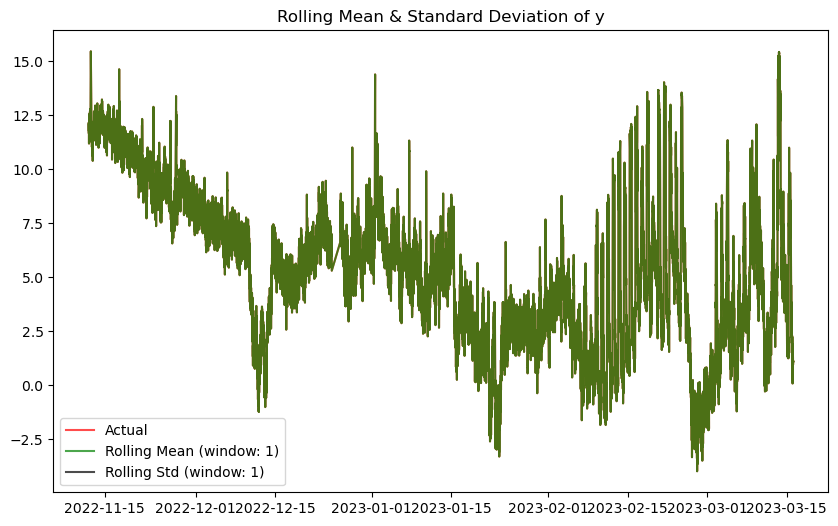

In [20]:
Output.calc_rolling_statistics("y",window=1)

----------------------------------------
739 values are dropped/imputed in y1.
---> Spline interpolation Imputation of y1: Using a mathematical function, the method estimates values that minimize overall curvature, thus obtaining a smooth surface passing through the input points. 
The function returns a (Physical) cleaned DataFrame with the column y1(statically) cleaned. The other parameters are not yet cleaned.
----------------------------------------
739 values are dropped/imputed in y1.
The rows with physical impossible values are deleted. 
Visual check is advised with LakeAegeri raw.calc_rolling_statsitics(...,plot='Y')
->  A stationary Time Series is one which characteristics like mean and variance does not change over time.
Another way of checking for stationarity of the time series is using Augmented Dickey-Fuller (ADF) Test to check stationarity:
--------------------
Dickey-Fuller Test: 
with a p-value of 0.031, we reject the null hypothesis, that the data is stationary.
Test S

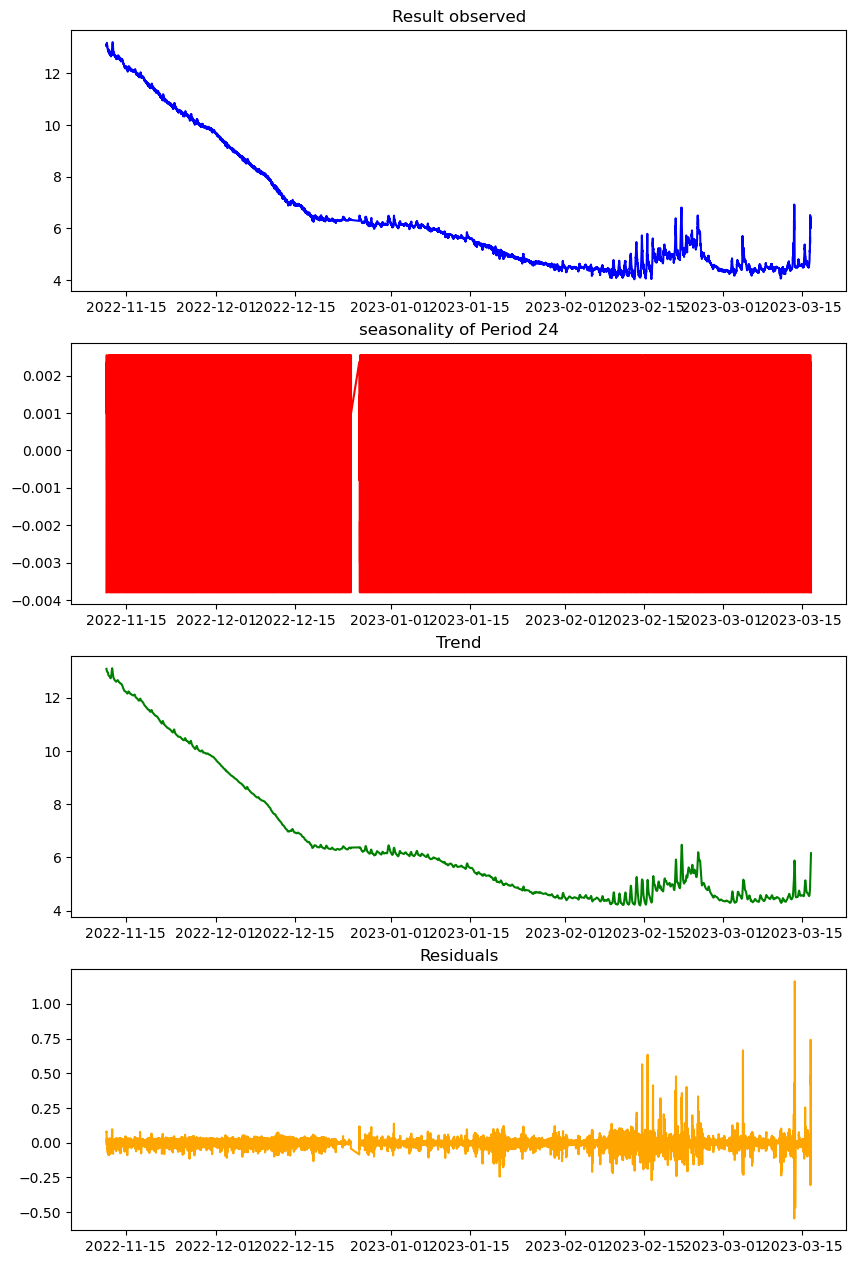

----------------------------------------
 215 values (residuals) are dropped/imputed in y1. 


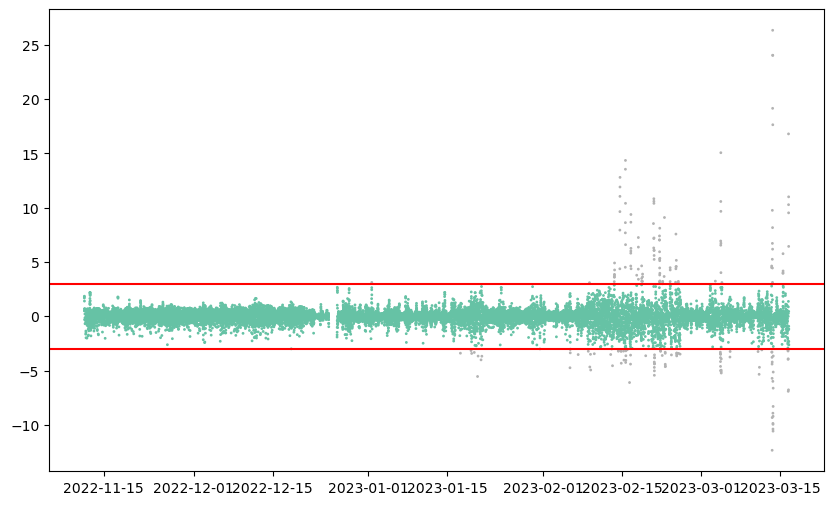

---> Splines Imputation of y1. It looks at outlier and puts a mathematical function over the dataset. The method estimates values that minimize overall curvature, thus obtaining a smooth surface passing through the input points. Spline interpolation is computationally efficient and can be used to interpolate large datasets quickly and accurately.
The method returns an instance of the class Data (with the whole DataFrame with the (timeseries) cleaned column y1). The physical impossible outliers are not cleaned in this method.


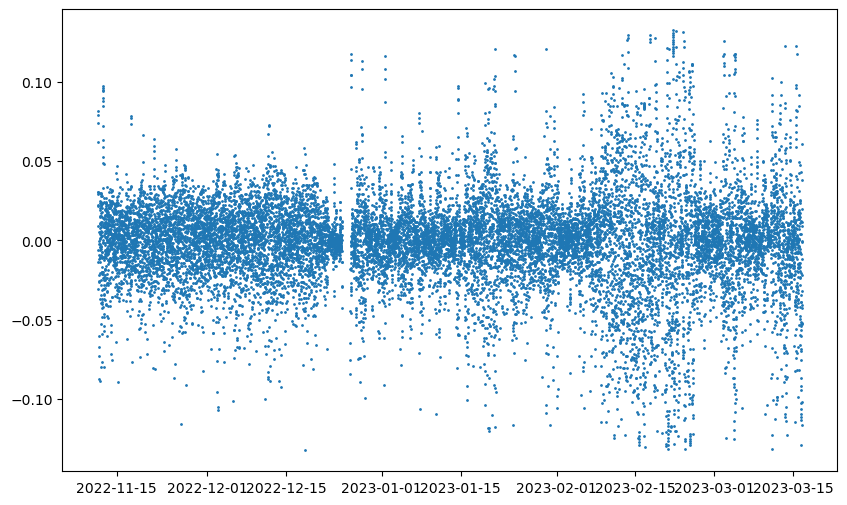

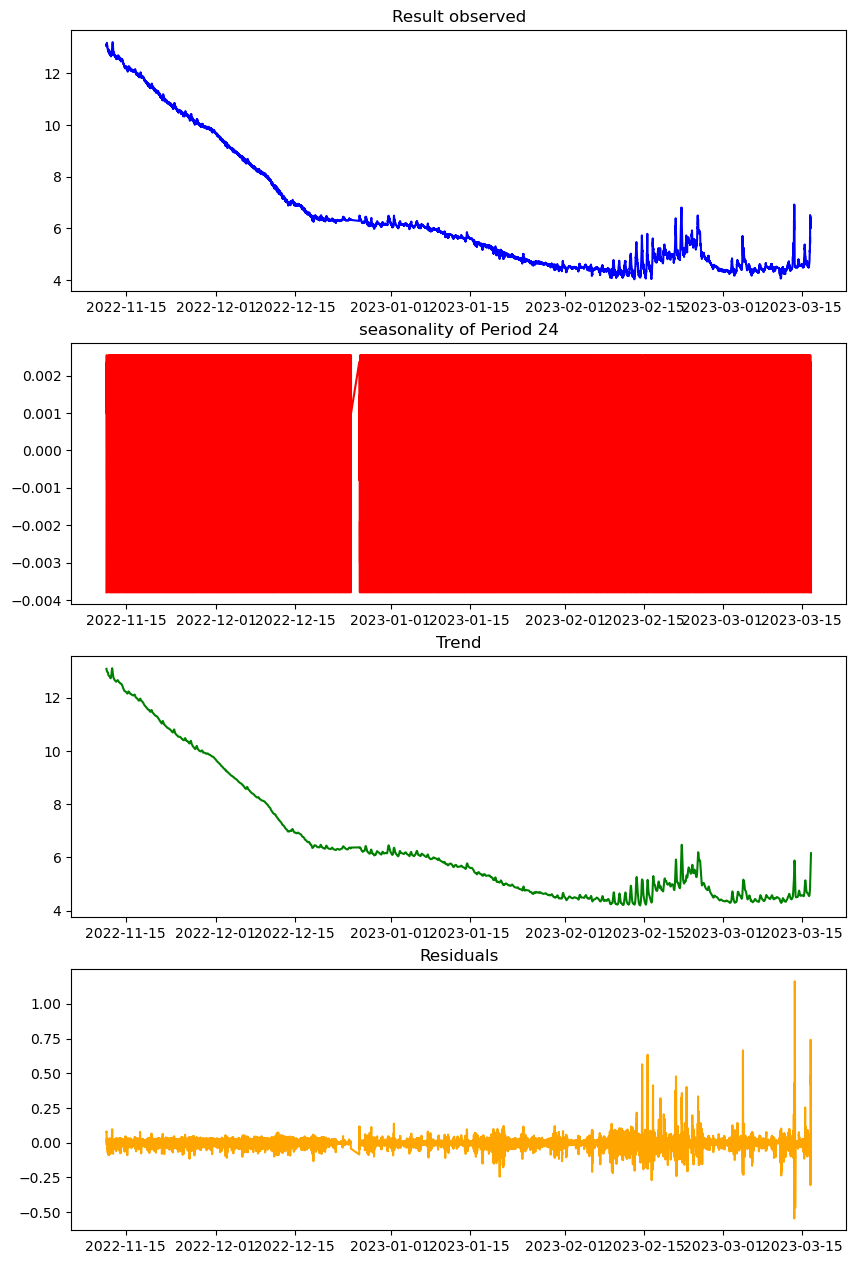

----------------------------------------
 215 values (residuals) are dropped/imputed in y1. 


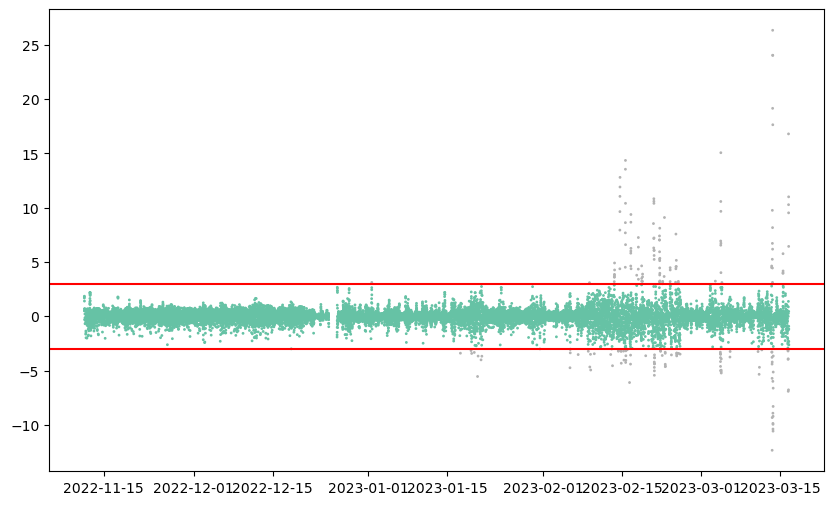

---> Simple imputation of y1: It looks at the normalized residuals and sets >3 values to 3 and <-3 values to -3.
The method returns an instance of the class Data (with the whole DataFrame with the (timeseries) cleaned column y1). The physical impossible outliers are not cleaned in this method.


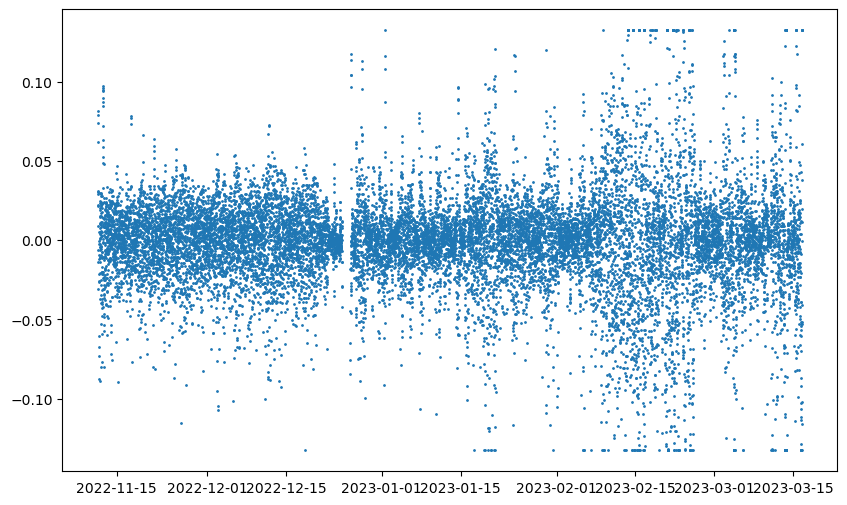

----------------------------------------
 1057 values are dropped/imputed in skin temperature of LakeAegeri raw.
739 values are dropped/imputed in bulk temperature  of LakeAegeri raw.
1 values are dropped/imputed in air temperature  of LakeAegeri raw. 
The rows with physical impossible values are deleted.
----------------------------------------
 1057 values are dropped/imputed in skin temperature of LakeAegeri raw.
739 values are dropped/imputed in bulk temperature  of LakeAegeri raw.
1 values are dropped/imputed in air temperature  of LakeAegeri raw. 
---> Spline interpolation Imputation of skin and bulk temperature: Using a mathematical function, the method estimates values that minimize overall curvature, thus obtaining a smooth surface passing through the input points. 
The function returns a (Physical) cleaned DataFrame with the columns airtemp, skin & bulk temperature (physicaly) cleaned. The other parameters are not yet cleaned.
----------------------------------------
739 valu

DataFrame LakeAegeri raw with columns: ['y', 'y1', 'datetime', 'air_temp', 'wind_speed', 'air_pressure', 'relative_humidity', 'solar_irradiance', 'meteo_timestamp']

In [21]:
LakeAegeri.remove_outliers_static("y1",imputation="y")
LakeAegeri.remove_outliers_static("y1",imputation="n")
LakeAegeri.check_stationarity("y1")
LakeAegeri.detect_outlier("y1",splines_imputation="y")
LakeAegeri.detect_outlier("y1",splines_imputation="n")
LakeAegeri.remove_outliers_temperature(skin_column_name="y",bulk_column_name="y1",airtemp_column_name="air_temp",imputation="n")
LakeAegeri.remove_outliers_temperature(skin_column_name="y",bulk_column_name="y1",airtemp_column_name="air_temp",imputation="y")
LakeAegeri.remove_outliers_static("y1",imputation="y")
LakeAegeri.remove_outliers_static("y1",imputation="n")

# Geneva BUC csv to big dataframe (FOR EXPORT THE DATAFRAME TO CSV FOR FURTHER INTERPRETATION)

In [22]:
import glob
import os

path="./data/Geneva/skin_temp/BUC_1m_csv"

all_files = glob.glob(os.path.join(path, "*.csv"))

df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
df=df.set_index("x")
df_datetime = np.array([datetime.fromtimestamp(ts) for ts in df.index])
df['datetime'] = df_datetime
# x: time; y: Skin temp; y1: Rel hum; y2: Solar irrad; y3: wind speed; y4: wind dir; y5: rainfal; y6: air press
df=df[["datetime","y","y1","y2","y3","y4","y5","y6"]]

,datetime,y,y1,y2,y3,y4,y5,y6
x,,,,,,,,
1473332400,2016-09-08 13:00:00,20.47,NaN,NaN,NaN,NaN,NaN,NaN
1473336000,2016-09-08 14:00:00,21.12,NaN,NaN,NaN,NaN,NaN,NaN
1473339600,2016-09-08 15:00:00,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1473343200,2016-09-08 16:00:00,22.50,NaN,NaN,NaN,NaN,NaN,NaN
1473346800,2016-09-08 17:00:00,23.04,NaN,NaN,NaN,NaN,NaN,NaN


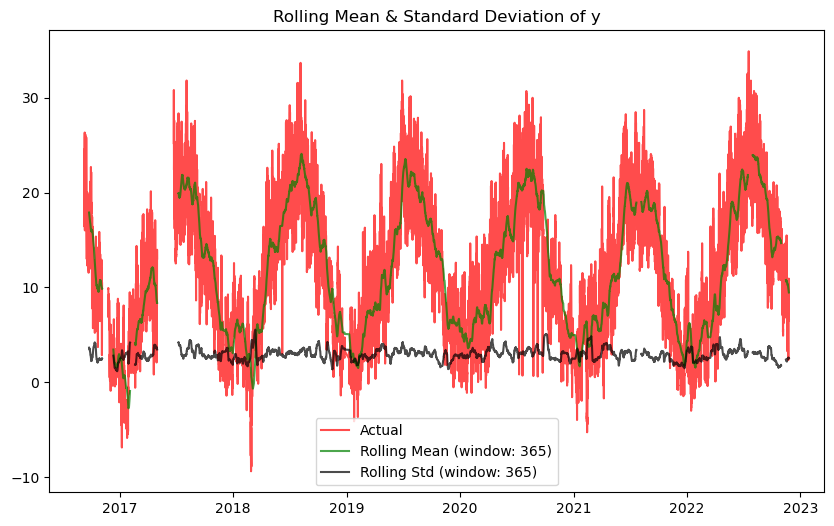

In [23]:
display(df.head())
BUC_geneva=Data(df,"BUC Geneva Raw",set_index_datetime_int="n")
BUC_geneva.calc_rolling_statistics("y",window=365,show_plot="y")

# Lake Aegeri Cleaning Process and saving as CSV

In [24]:
dataframe = pd.read_csv("./data/df_aegeri_skin.csv")
name = "LakeAegeriRaw"
LakeAegeri_raw = Data(dataframe, name)
LakeAegeri_raw.rename_columns(columns={"y": "skin_temp", "y1": "bulk_temp"})

LakeAegeri_cleaned=Data(dataframe=LakeAegeri_raw.dataframe.copy(),name="LakeAegeriCleaned",set_index_datetime_int="n")


----------------------------------------
 1057 values are dropped/imputed in skin temperature of LakeAegeriCleaned.
739 values are dropped/imputed in bulk temperature  of LakeAegeriCleaned.
1 values are dropped/imputed in air temperature  of LakeAegeriCleaned. 
---> Spline interpolation Imputation of skin and bulk temperature: Using a mathematical function, the method estimates values that minimize overall curvature, thus obtaining a smooth surface passing through the input points. 
The function returns a (Physical) cleaned DataFrame with the columns airtemp, skin & bulk temperature (physicaly) cleaned. The other parameters are not yet cleaned.
----------------------------------------
365 values are dropped/imputed in wind_speed.
---> Spline interpolation Imputation of wind_speed: Using a mathematical function, the method estimates values that minimize overall curvature, thus obtaining a smooth surface passing through the input points. 
The function returns a (Physical) cleaned DataFra

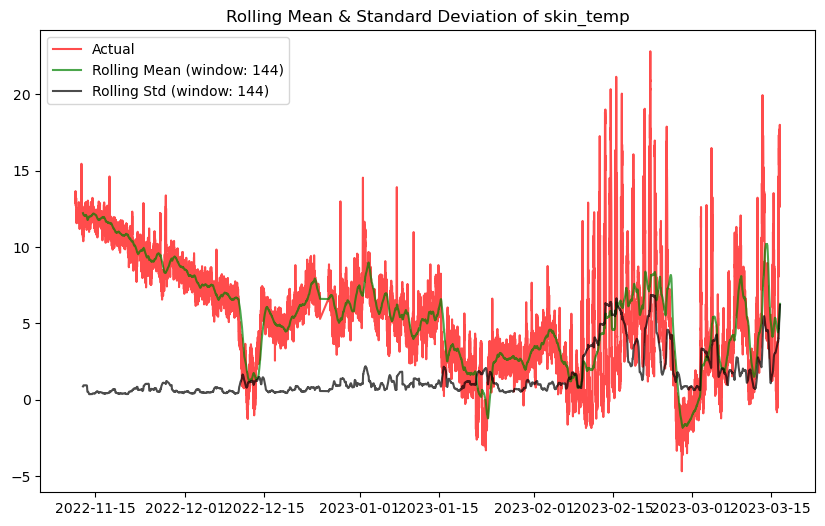

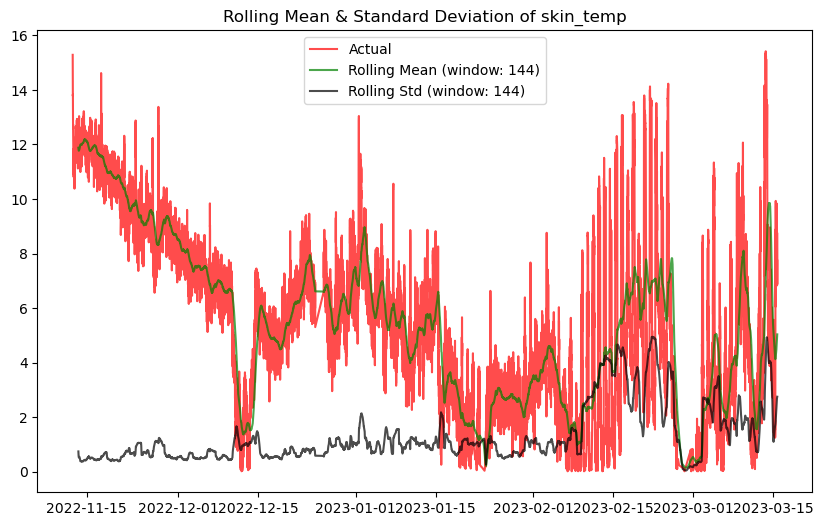

In [25]:
LakeAegeri_cleaned=LakeAegeri_cleaned.remove_outliers_temperature(skin_column_name="skin_temp",bulk_column_name="bulk_temp",airtemp_column_name="air_temp",imputation="y")

for i in ["wind_speed","air_pressure","relative_humidity","solar_irradiance"]:
    LakeAegeri_cleaned=LakeAegeri_cleaned.remove_outliers_static(i,imputation="y")

for i in ["skin_temp","bulk_temp"]:
    LakeAegeri_cleaned=LakeAegeri_cleaned.detect_outlier(column=i,splines_imputation="y",PERIOD=144,display_plots="n")



LakeAegeri_raw.calc_rolling_statistics(column="skin_temp",window=144,show_plot="y")
LakeAegeri_cleaned.calc_rolling_statistics(column="skin_temp",window=144,show_plot="y")